**КТ2 - Выполнил Кирилл Запорожченко, ФЗ-11**

### Object Detection

In [1]:
import numpy as np
import os
from PIL import Image, ImageDraw
import json
from datasets import Dataset, Value
from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor
import albumentations
import numpy as np
import torch
from transformers import AutoModelForObjectDetection
from transformers import TrainingArguments

np.random.seed(242)

c:\Users\Kreal\miniconda3\envs\ts\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Загружаем датасет

In [2]:
import os
import json
from PIL import Image

# Путь к папке с изображениями
image_dir = 'C:\\Users\\Kreal\\Documents\\VUZ\\psuObjectDecection\\KT2\\16. Market.v6i.coco\\train'

# Загрузка аннотаций
with open(os.path.join(image_dir, '_annotations.coco.json')) as f:
    data = json.load(f)

# Создание словаря для хранения изображений и их аннотаций
dataset = []

# Обход по всем изображениям
for image_info in data['images']:
    # Загрузка изображения с помощью PIL
    image = Image.open(os.path.join(image_dir, image_info['file_name']))
    
    # Находим соответствующие аннотации для этого изображения
    image_annotations = [a for a in data['annotations'] if a['image_id'] == image_info['id']]
    
    # Собираем информацию об объектах на изображении
    objects = {
        'id': [a['id'] for a in image_annotations],
        'area': [a['area'] for a in image_annotations],
        'bbox': [a['bbox'] for a in image_annotations],
        'category': [a['category_id'] for a in image_annotations]
    }
    
    # Добавляем словарь с информацией об изображении в датасет
    dataset.append({
        'image_id': image_info['id'],
        'image': image,
        'width': image_info['width'],
        'height': image_info['height'],
        'objects': objects
    })


Преобразуем к типу данных DatasetDict

In [3]:
# Разделение датасета на обучающую и тестовую выборки
train_data, test_data = train_test_split(dataset, test_size=0.2)

# Преобразование в тип Dataset
train_dataset = Dataset.from_dict({k: [dic[k] for dic in train_data] for k in train_data[0]})
test_dataset = Dataset.from_dict({k: [dic[k] for dic in test_data] for k in test_data[0]})

# Объединение в DatasetDict
dataset_dict = {'train': train_dataset, 'test': test_dataset}

print(dataset_dict)

{'train': Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 1231
}), 'test': Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 308
})}


In [4]:
dataset_dict["train"][0]

{'image_id': 577,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=416x416>,
 'width': 416,
 'height': 416,
 'objects': {'area': [5950.219,
   6146.894,
   5951.893,
   5897.529,
   5674.309,
   5581.108,
   5823.4,
   5864.727,
   5654.658,
   5421.804,
   1543.469,
   1357.581,
   1262.756,
   1195.262],
  'bbox': [[130.0, 13.0, 145.181, 40.985],
   [127.0, 54.0, 146.075, 42.08],
   [122.0, 95.0, 147.258, 40.418],
   [120.0, 137.0, 146.188, 40.342],
   [118.0, 177.0, 143.341, 39.586],
   [115.0, 217.0, 143.87, 38.793],
   [113.0, 257.0, 143.946, 40.455],
   [110.0, 296.0, 144.159, 40.682],
   [108.0, 337.0, 143.53, 39.397],
   [105.0, 377.0, 142.825, 37.961],
   [0.0, 46.0, 38.953, 39.624],
   [0.0, 88.0, 35.977, 37.734],
   [0.0, 128.0, 34.01, 37.129],
   [0.0, 167.0, 32.307, 36.997]],
  'category': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4],
  'id': [10162,
   10163,
   10164,
   10165,
   10166,
   10167,
   10168,
   10169,
   10170,
   10171,
   10172,
   10173,


Отрисуем для примера

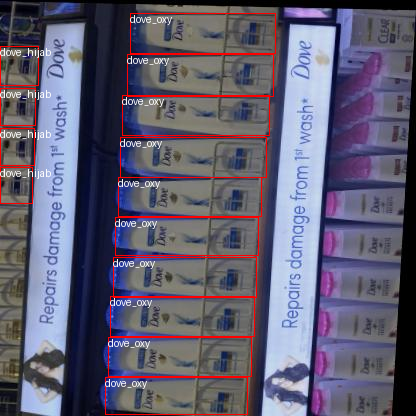

{0: 'MTSOS_New', 1: 'clinic_strong', 2: 'domex_lime', 3: 'domex_ocen', 4: 'dove_hijab', 5: 'dove_oxy', 6: 'dove_pink', 7: 'dove_white', 8: 'gl_men_crm', 9: 'gl_men_fw', 10: 'gl_wntr_crm', 11: 'glucomax_d', 12: 'horlicks_jr_bib_2', 13: 'horlicks_jr_jar_1', 14: 'horlicks_pouch', 15: 'knorr_corn', 16: 'knorr_frd_chicken', 17: 'knorr_hot_sour', 18: 'knorr_thai', 19: 'lb_blue_handwash', 20: 'lb_blue_packet', 21: 'lb_lmn_bottle_1l', 22: 'lb_lmn_handwash', 23: 'lb_lmn_packet', 24: 'lb_red_bottle_1l', 25: 'lb_red_gallon_5l', 26: 'lb_red_handwash', 27: 'lb_red_packet', 28: 'lux_almond', 29: 'lux_aloe', 30: 'lux_orchd', 31: 'lux_soft', 32: 'pepsodent_pwdr', 33: 'ponds_antibac', 34: 'ponds_cold_crm', 35: 'ponds_lgt_oil_fw', 36: 'ponds_moist_body', 37: 'ponds_oil_cntr_fw', 38: 'ponds_super_lgt', 39: 'ponds_van_crm', 40: 'rin_lqd', 41: 'rin_pwdr', 42: 'sunsilk_perfect', 43: 'surfxl_lqd', 44: 'surfxl_pwdr', 45: 'tresemme_hd', 46: 'tresemme_ks_wt', 47: 'tresemme_nr', 48: 'vaseline_ln_white_lc', 49: '

In [5]:
from IPython.display import display

# Первый элемент в датасете
data_item = dataset_dict["train"][0]

# Изображение и аннотации
image = data_item["image"]
annotations = data_item["objects"]

# Создаем объект для рисования на изображении
draw = ImageDraw.Draw(image)

# Получаем категории из данных
categories = [cat['name'] for cat in data['categories']]

# Создаем словари для преобразования между ID и именами категорий
id2label = {cat['id']: cat['name'] for cat in data['categories']}
label2id = {v: k for k, v in id2label.items()}

# Рисуем bounding boxes для каждого объекта на изображении
for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    if max(box) > 1.0:
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    else:
        x1 = int(x * image.width)
        y1 = int(y * image.height)
        x2 = int((x + w) * image.width)
        y2 = int((y + h) * image.height)
    draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
    draw.text((x1, y1), id2label[class_idx], fill="white")

# Показываем изображение
display(image)
print(id2label)
print(label2id)

In [6]:
checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

c:\Users\Kreal\miniconda3\envs\ts\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
# создаем объект преобразований для изображений
transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [8]:
# преобразуем аннотации
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

# для создания одного батча - скомбинируем изображение и аннотацию
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

Нужно отфильтровать данные, которые вызывают ошибки при комбинировании изображения и аннотации

In [9]:
len(dataset_dict["train"])

1231

In [10]:
tempdataset = dataset_dict.copy()
error_vals = []

# пример того, как осуществляется комбинирование изображения и аннотации
tempdataset["train"] = tempdataset["train"].with_transform(transform_aug_ann)
for i in range(1231):
    try:
      tempdataset["train"][i]
    except:
       error_vals.append(i)
error_vals


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


[13,
 15,
 16,
 18,
 19,
 20,
 21,
 47,
 50,
 57,
 59,
 64,
 85,
 96,
 101,
 103,
 118,
 122,
 131,
 152,
 165,
 168,
 170,
 172,
 183,
 186,
 209,
 210,
 211,
 223,
 229,
 240,
 257,
 258,
 283,
 289,
 297,
 326,
 339,
 346,
 358,
 364,
 373,
 378,
 392,
 407,
 412,
 413,
 416,
 419,
 420,
 424,
 425,
 434,
 438,
 449,
 450,
 467,
 504,
 517,
 522,
 527,
 532,
 542,
 543,
 553,
 563,
 578,
 608,
 622,
 626,
 651,
 663,
 664,
 665,
 668,
 679,
 687,
 689,
 694,
 729,
 733,
 739,
 749,
 777,
 779,
 789,
 792,
 793,
 801,
 806,
 810,
 830,
 838,
 873,
 874,
 875,
 881,
 886,
 889,
 906,
 914,
 921,
 925,
 951,
 964,
 967,
 986,
 1016,
 1021,
 1025,
 1027,
 1032,
 1048,
 1053,
 1068,
 1074,
 1083,
 1095,
 1113,
 1143,
 1145,
 1164,
 1166,
 1173,
 1188,
 1196,
 1197,
 1201,
 1208,
 1215]

In [11]:
print(f"Всего записей данных, вызвавших ошибки = {len(error_vals)}")

Всего записей данных, вызвавших ошибки = 131


In [12]:
#Удаляем некорректные данные
ndataset = dataset_dict.copy()

keep = [i for i in range(len(ndataset["train"])) if i not in error_vals]
ndataset["train"] = ndataset["train"].select(keep)

Комбинируем изображения и аннотации

In [13]:
ndataset["train"] = ndataset["train"].with_transform(transform_aug_ann)
ndataset["train"][15]

{'pixel_values': tensor([[[-1.9809, -1.9809, -1.9809,  ..., -1.9467, -1.9124, -1.8953],
          [-1.9809, -1.9809, -1.9809,  ..., -1.9124, -1.8953, -1.8782],
          [-1.9809, -1.9809, -1.9809,  ..., -1.8610, -1.8610, -1.8610],
          ...,
          [-1.9809, -1.9809, -1.9809,  ..., -1.8782, -1.8610, -1.8439],
          [-1.9809, -1.9809, -1.9809,  ..., -1.8782, -1.8610, -1.8439],
          [-1.9809, -1.9809, -1.9809,  ..., -1.8782, -1.8610, -1.8439]],
 
         [[-1.8957, -1.8957, -1.8957,  ..., -1.6506, -1.6155, -1.5980],
          [-1.8957, -1.8957, -1.8957,  ..., -1.6331, -1.5980, -1.5805],
          [-1.8957, -1.8957, -1.8957,  ..., -1.5980, -1.5805, -1.5630],
          ...,
          [-1.8782, -1.8782, -1.8782,  ..., -1.8081, -1.7906, -1.7906],
          [-1.8782, -1.8782, -1.8782,  ..., -1.8081, -1.7906, -1.7906],
          [-1.8782, -1.8782, -1.8782,  ..., -1.8081, -1.7906, -1.7906]],
 
         [[-1.6650, -1.6650, -1.6650,  ...,  0.6182,  0.6531,  0.6879],
          [-

In [14]:
# делаем всё красивее и удобнее
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [15]:
# определяем модель (согласно названию в 'checkpoint')
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [16]:
# определяем гиперпараметры
training_args = TrainingArguments(
    output_dir="maketv6imodeloutput",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

In [17]:
!huggingface-cli login #выполнил из консоли, из блокнота не получилось

usage: huggingface-cli <command> [<args>]
huggingface-cli: error: unrecognized arguments: #выполнил из консоли, из блокнота не получилось


In [18]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
1
NVIDIA GeForce RTX 3060


Обучим модель

In [19]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=ndataset["train"],
    tokenizer=image_processor,
)

trainer.train()

  0%|          | 0/1380 [00:00<?, ?it/s]c:\Users\Kreal\miniconda3\envs\ts\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\Kreal\miniconda3\envs\ts\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  4%|▎         | 50/1380 [00:48<19:57,  1.11it/s] 

{'loss': 5.9493, 'grad_norm': 73.31681823730469, 'learning_rate': 9.63768115942029e-06, 'epoch': 0.36}


  7%|▋         | 100/1380 [01:33<19:14,  1.11it/s]

{'loss': 5.2523, 'grad_norm': 37.5096549987793, 'learning_rate': 9.275362318840581e-06, 'epoch': 0.72}


 11%|█         | 150/1380 [02:18<18:26,  1.11it/s]

{'loss': 4.8498, 'grad_norm': 24.489912033081055, 'learning_rate': 8.91304347826087e-06, 'epoch': 1.09}


 14%|█▍        | 200/1380 [03:03<17:43,  1.11it/s]

{'loss': 4.6397, 'grad_norm': 25.594619750976562, 'learning_rate': 8.55072463768116e-06, 'epoch': 1.45}


 18%|█▊        | 250/1380 [03:52<16:54,  1.11it/s]

{'loss': 4.5509, 'grad_norm': 87.71902465820312, 'learning_rate': 8.188405797101449e-06, 'epoch': 1.81}


 22%|██▏       | 300/1380 [04:36<16:14,  1.11it/s]

{'loss': 4.3841, 'grad_norm': 25.637939453125, 'learning_rate': 7.82608695652174e-06, 'epoch': 2.17}


 25%|██▌       | 350/1380 [05:21<15:44,  1.09it/s]

{'loss': 4.2961, 'grad_norm': 233.34140014648438, 'learning_rate': 7.4637681159420295e-06, 'epoch': 2.54}


 29%|██▉       | 400/1380 [06:07<14:41,  1.11it/s]

{'loss': 4.3019, 'grad_norm': 33.32585525512695, 'learning_rate': 7.10144927536232e-06, 'epoch': 2.9}


 33%|███▎      | 450/1380 [06:54<13:44,  1.13it/s]

{'loss': 4.1595, 'grad_norm': 61.073036193847656, 'learning_rate': 6.739130434782609e-06, 'epoch': 3.26}


 36%|███▌      | 500/1380 [07:39<13:17,  1.10it/s]

{'loss': 4.1723, 'grad_norm': 66.80622863769531, 'learning_rate': 6.376811594202898e-06, 'epoch': 3.62}


 40%|███▉      | 550/1380 [08:24<12:34,  1.10it/s]

{'loss': 4.1905, 'grad_norm': 140.39511108398438, 'learning_rate': 6.014492753623189e-06, 'epoch': 3.99}


 43%|████▎     | 600/1380 [09:09<11:45,  1.11it/s]

{'loss': 4.0882, 'grad_norm': 46.77519607543945, 'learning_rate': 5.652173913043479e-06, 'epoch': 4.35}


 47%|████▋     | 650/1380 [09:57<11:02,  1.10it/s]

{'loss': 4.0842, 'grad_norm': 26.723974227905273, 'learning_rate': 5.289855072463769e-06, 'epoch': 4.71}


 51%|█████     | 700/1380 [10:42<10:28,  1.08it/s]

{'loss': 4.0773, 'grad_norm': 20.691186904907227, 'learning_rate': 4.927536231884059e-06, 'epoch': 5.07}


 54%|█████▍    | 750/1380 [11:28<09:43,  1.08it/s]

{'loss': 4.0723, 'grad_norm': 26.90337371826172, 'learning_rate': 4.565217391304348e-06, 'epoch': 5.43}


 58%|█████▊    | 800/1380 [12:14<08:47,  1.10it/s]

{'loss': 3.9613, 'grad_norm': 26.432558059692383, 'learning_rate': 4.202898550724638e-06, 'epoch': 5.8}


 62%|██████▏   | 850/1380 [13:01<08:01,  1.10it/s]

{'loss': 3.9281, 'grad_norm': 58.986820220947266, 'learning_rate': 3.840579710144928e-06, 'epoch': 6.16}


 65%|██████▌   | 900/1380 [13:46<07:15,  1.10it/s]

{'loss': 4.054, 'grad_norm': 12.719728469848633, 'learning_rate': 3.4782608695652175e-06, 'epoch': 6.52}


 69%|██████▉   | 950/1380 [14:32<06:35,  1.09it/s]

{'loss': 3.968, 'grad_norm': 27.061452865600586, 'learning_rate': 3.1159420289855073e-06, 'epoch': 6.88}


 72%|███████▏  | 1000/1380 [15:17<05:43,  1.10it/s]

{'loss': 4.0331, 'grad_norm': 41.32093048095703, 'learning_rate': 2.7536231884057974e-06, 'epoch': 7.25}


 76%|███████▌  | 1050/1380 [16:05<04:53,  1.12it/s]

{'loss': 3.9685, 'grad_norm': 31.79812240600586, 'learning_rate': 2.391304347826087e-06, 'epoch': 7.61}


 80%|███████▉  | 1100/1380 [16:50<04:16,  1.09it/s]

{'loss': 3.8798, 'grad_norm': 39.975364685058594, 'learning_rate': 2.028985507246377e-06, 'epoch': 7.97}


 83%|████████▎ | 1150/1380 [17:35<03:28,  1.10it/s]

{'loss': 3.8721, 'grad_norm': 41.6415901184082, 'learning_rate': 1.6666666666666667e-06, 'epoch': 8.33}


 87%|████████▋ | 1200/1380 [18:20<02:43,  1.10it/s]

{'loss': 3.9907, 'grad_norm': 38.52490234375, 'learning_rate': 1.3043478260869566e-06, 'epoch': 8.7}


 91%|█████████ | 1250/1380 [19:07<01:57,  1.11it/s]

{'loss': 3.9394, 'grad_norm': 22.74877166748047, 'learning_rate': 9.420289855072465e-07, 'epoch': 9.06}


 94%|█████████▍| 1300/1380 [19:52<01:11,  1.13it/s]

{'loss': 3.926, 'grad_norm': 26.568681716918945, 'learning_rate': 5.797101449275363e-07, 'epoch': 9.42}


 98%|█████████▊| 1350/1380 [20:37<00:27,  1.08it/s]

{'loss': 3.8835, 'grad_norm': 27.998149871826172, 'learning_rate': 2.173913043478261e-07, 'epoch': 9.78}


100%|██████████| 1380/1380 [21:04<00:00,  1.09it/s]

{'train_runtime': 1264.3732, 'train_samples_per_second': 8.7, 'train_steps_per_second': 1.091, 'train_loss': 4.23267030024874, 'epoch': 10.0}


TrainOutput(global_step=1380, training_loss=4.23267030024874, metrics={'train_runtime': 1264.3732, 'train_samples_per_second': 8.7, 'train_steps_per_second': 1.091, 'total_flos': 5.25779755776e+18, 'train_loss': 4.23267030024874, 'epoch': 10.0})

In [20]:
model.save_pretrained("pretrained_dataset")

In [20]:
tempdataset = dataset_dict.copy()

error_vals = []

# пример того, как осуществляется комбинирование изображения и аннотации
tempdataset["test"] = tempdataset["test"].with_transform(transform_aug_ann)
for i in range(len(tempdataset["test"])):
    try:
      tempdataset["test"][i]
    except:
       error_vals.append(i)

#Удаляем некорректные данные
cdataset = dataset_dict.copy()

keep = [i for i in range(len(cdataset["test"])) if i not in error_vals]
cdataset["test"] = cdataset["test"].select(keep)
cdataset["test"] = cdataset["test"].with_transform(transform_aug_ann)


In [21]:
import json

# форматируем аннотации как для трейн выборки
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations


# сохраняем изображения и аннотации к ним
def save_cppe5_annotation_file_images(maketv6i):
    output_json = {}
    path_output_cppe5 = f"{os.getcwd()}/maketv6i/"

    if not os.path.exists(path_output_cppe5):
        os.makedirs(path_output_cppe5)

    path_anno = os.path.join(path_output_cppe5, "maketv6i_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in maketv6i:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(maketv6i["image"], maketv6i["image_id"]):
        path_img = os.path.join(path_output_cppe5, f"{img_id}.png")
        im.save(path_img)

    return path_output_cppe5, path_anno

In [22]:
import torchvision


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, ann_file):
        super().__init__(img_folder, ann_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.image_processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


im_processor = AutoImageProcessor.from_pretrained("maketv6imodeloutput")

filtered_test_dataset_dict = dataset_dict.copy()
keep = [i for i in range(len(filtered_test_dataset_dict["test"])) if i not in error_vals]
filtered_test_dataset_dict["test"] = filtered_test_dataset_dict["test"].select(keep)

path_output_cppe5, path_anno = save_cppe5_annotation_file_images(filtered_test_dataset_dict["test"])
test_ds_coco_format = CocoDetection(path_output_cppe5, im_processor, path_anno)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [34]:
# загружаем метрики и смотрим что получилось
import evaluate
from tqdm import tqdm

model = AutoModelForObjectDetection.from_pretrained("maketv6imodeloutput")
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn
)

enumerate(tqdm(val_dataloader))

for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)

        results = im_processor.post_process(outputs, orig_target_sizes)

        module.add(prediction=results, reference=labels)

        del batch

        print(idx)



  0%|          | 0/34 [00:00<?, ?it/s]




0


1


  6%|▌         | 2/34 [00:15<04:15,  7.99s/it]


KeyboardInterrupt: 

In [35]:
# загружаем метрики и смотрим что получилось
import evaluate
from tqdm import tqdm

model = AutoModelForObjectDetection.from_pretrained("maketv6imodeloutput")
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn
)

total_batches = len(val_dataloader)
print(f"Total batches: {total_batches}")

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)  # convert outputs of model to Pascal VOC format (xmin, ymin, xmax, ymax)

        module.add(prediction=results, reference=labels)

        print(f"Batch {idx+1} processed")
        
        del batch

Total batches: 34


Batch 1 processed


Batch 2 processed


Batch 3 processed


Batch 4 processed


Batch 5 processed


Batch 6 processed


Batch 7 processed


Batch 8 processed


Batch 9 processed


Batch 10 processed


Batch 11 processed


Batch 12 processed


Batch 13 processed


Batch 14 processed


Batch 15 processed


Batch 16 processed


Batch 17 processed


Batch 18 processed


Batch 19 processed


Batch 20 processed


Batch 21 processed


Batch 22 processed


Batch 23 processed


Batch 24 processed


Batch 25 processed


Batch 26 processed


Batch 27 processed


Batch 28 processed


Batch 29 processed


Batch 30 processed


Batch 31 processed


Batch 32 processed


Batch 33 processed



100%|██████████| 34/34 [03:23<00:00,  6.00s/it]

Batch 34 processed


In [37]:
results

[{'scores': tensor([0.0207, 0.0174, 0.0197, 0.0181, 0.0150, 0.0213, 0.0229, 0.0228, 0.0142,
          0.0138, 0.0205, 0.0210, 0.0192, 0.0260, 0.0185, 0.0148, 0.0136, 0.0189,
          0.0196, 0.0202, 0.0196, 0.0196, 0.0221, 0.0210, 0.0180, 0.0217, 0.0198,
          0.0206, 0.0181, 0.0135, 0.0193, 0.0234, 0.0176, 0.0227, 0.0202, 0.0175,
          0.0187, 0.0181, 0.0241, 0.0189, 0.0186, 0.0188, 0.0169, 0.0192, 0.0142,
          0.0163, 0.0188, 0.0198, 0.0141, 0.0184, 0.0146, 0.0165, 0.0184, 0.0160,
          0.0210, 0.0214, 0.0240, 0.0176, 0.0179, 0.0231, 0.0160, 0.0213, 0.0270,
          0.0151, 0.0221, 0.0203, 0.0140, 0.0208, 0.0182, 0.0188, 0.0201, 0.0209,
          0.0200, 0.0215, 0.0196, 0.0170, 0.0167, 0.0182, 0.0156, 0.0143, 0.0218,
          0.0167, 0.0193, 0.0177, 0.0161, 0.0207, 0.0196, 0.0184, 0.0214, 0.0212,
          0.0181, 0.0200, 0.0214, 0.0181, 0.0237, 0.0198, 0.0158, 0.0187, 0.0209,
          0.0183]),
  'labels': tensor([54, 54, 54, 54, 54, 54, 54, 54, 37, 54, 54, 54, 

In [38]:
result = module.compute()
print(result)

Accumulating evaluation results...
DONE (t=0.30s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [ ]:
# давай отрисуем пример для лучшей наглядности
example_image = cppe5["train"][4]["image"]
draw = ImageDraw.Draw(example_image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

example_image